In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
import math
from math import sqrt
import re
from datetime import datetime
import datetime
import time

In [2]:
DATA_FOLDER = 'data'

### A. Loading consumption phase
Load the EPFL charging stations excel file into a `DataFrames`. 

In [3]:
cs_dataframe = pd.read_excel("{}/EPFL-data-extract.xlsx".format(DATA_FOLDER), index_col=0) 

In [37]:
def nb_minutes(EndDate, BeginDate):
    delta = EndDate - BeginDate
    nb_min_final_day = delta.seconds//60
    nb_days = delta.days
    nb_min = nb_min_final_day + nb_days*24*60 + 1
    return nb_min

In [38]:
delta_vect = cs_dataframe.apply(lambda x : nb_minutes(x.EndDate, x.BeginDate), axis=1) #compute minutes of charge
cs_dataframe["ChargingDuration"] = delta_vect 
cs_dataframe["Power"] = cs_dataframe["PowerConsumption"] / cs_dataframe["ChargingDuration"] * 60 # compute power
#cs_df = cs_dataframe.drop('HashedUserId', axis=1)
cs_df = cs_dataframe
cs_df.head()

,ChargingStationId,ChargingStationPlugId,BeginDate,EndDate,PowerConsumption,HashedUserId,ChargingDuration,Power
ChargeLogId,,,,,,,,
4911,118,165,2013-11-22 09:02:37,2013-11-22 09:03:09,0,0x725B61EAA9973F5EF7FE6BE2033C5F264982C8C04ED3...,1,0.0
4912,118,166,2013-11-22 09:02:49,2013-11-22 09:03:21,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...,1,0.0
4913,118,166,2013-11-22 09:08:29,2013-11-22 09:09:17,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...,1,0.0
4914,118,166,2013-11-22 09:10:36,2013-11-22 09:10:54,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...,1,0.0
4915,118,166,2013-11-22 09:11:57,2013-11-22 09:12:13,0,0x70BD1D7BE1297329FE64409179DA9D1B789BE5283D0C...,1,0.0


Let's remove unrealistic charging powers:

In [39]:
cs_df_clean = cs_df[cs_df.Power < 30000] # removing outliers (P>30kW...)

### A.2 clustering each data into a hour-form

In [61]:
# year 2018,2019,2020 data
df = cs_df_clean[cs_df_clean.BeginDate.dt.year.isin([2020,2019,2018])]
df = df.reset_index()
df = df.drop(['ChargeLogId'],axis =1)

In [53]:
df.loc[1].BeginDate.strftime("%Y-%m-%d %H:%M")[-2:]

'04'

In [67]:
df['BD'] = df['BeginDate'].dt.date

In [69]:
df['ED'] = df['EndDate'].dt.date

In [73]:
df['BT'] = df['BeginDate'].dt.hour

In [74]:
df['ET'] = df['EndDate'].dt.hour

In [75]:
df.head()

,ChargingStationId,ChargingStationPlugId,BeginDate,EndDate,PowerConsumption,HashedUserId,ChargingDuration,Power,BD,ED,BT,ET
0,118,165,2018-01-03 10:19:46,2018-01-03 14:20:31,14665,0xE3EE93EC9E2473941860A1D21A97DD2ACEBF4E61DCAE...,241,3651.037344,2018-01-03,2018-01-03,10,14
1,118,166,2018-01-04 07:04:55,2018-01-04 12:31:54,11356,0xF0E30B0390A82D376F4AD684B97355C14F81CC98249B...,327,2083.669725,2018-01-04,2018-01-04,7,12
2,118,165,2018-01-04 08:40:47,2018-01-04 13:39:15,12538,0xE3EE93EC9E2473941860A1D21A97DD2ACEBF4E61DCAE...,299,2515.986622,2018-01-04,2018-01-04,8,13
3,118,165,2018-01-04 14:29:42,2018-01-04 15:39:32,10722,0x0897DA94B961CB920DB3A1EF91F3B59C40A18BFB1CAA...,70,9190.285714,2018-01-04,2018-01-04,14,15
4,118,166,2018-01-04 12:36:53,2018-01-04 16:09:33,2084,0xF17F83E4B3CA8A59E52ECFE331867F57D30E667A8116...,213,587.042254,2018-01-04,2018-01-04,12,16


In [160]:
df_quater = pd.DataFrame()
def power_quater(x):
    global df_quater
        
    start_minute = int(x.BeginDate.strftime("%Y-%m-%d %H:%M")[-2:])
   # timesteps = int((x.ChargingDuration - (60 - start_minute))/15) +1 \+ int((60 - start_minute)/15) + 1
    year = x.BeginDate.year
    month = x.BeginDate.month
    day = x.BeginDate.day
    hour = x.BeginDate.hour
    start_time = datetime.datetime(year,month,day,hour,15*int(start_minute/15))

        
    while start_time <= x.EndDate:
        delt = datetime.timedelta(minutes = 15)
        power_detail = [[start_time, x.Power]]
        df_quater = df_quater.append(power_detail)
        start_time += delt


In [161]:
df.apply(lambda x: power_quater(x), axis = 1)

0        None
1        None
2        None
3        None
4        None
         ... 
10176    None
10177    None
10178    None
10179    None
10180    None
Length: 10181, dtype: object

In [164]:
df_quater.columns = ['Date', 'Power']

In [169]:
his_char = pd.DataFrame(df_quater.groupby('Date').Power.sum()).reset_index()

In [173]:
his_char[his_char.Date.dt.date == datetime.date(2020,3,9)]

,Date,Power
41290,2020-03-09 05:00:00,9602.857143
41291,2020-03-09 05:15:00,9602.857143
41292,2020-03-09 05:30:00,12735.238095
41293,2020-03-09 05:45:00,12735.238095
41294,2020-03-09 06:00:00,12735.238095
...,...,...
41361,2020-03-09 22:45:00,3723.192488
41362,2020-03-09 23:00:00,3723.192488
41363,2020-03-09 23:15:00,3723.192488
41364,2020-03-09 23:30:00,3723.192488


#### to compensate missing time

In [271]:
begin = datetime.datetime(2018,1,2,0,0,0)
end = datetime.datetime(2020,3,12,23,45,0)

d = begin
delta = datetime.timedelta(minutes = 15)
power_list = his_char

while d <= end:
    if d not in pd.to_datetime(power_list.Date.values):
        new = pd.DataFrame([[d, 0]])
        new.columns = ['Date', 'Power']
        power_list = power_list.append(new)
        d += delta
    else:
        d += delta
        continue

In [272]:
power_list = power_list.sort_values(by = ['Date'], ascending = True).reset_index(drop = True)

In [274]:
aa = power_list[power_list.Date.dt.date == datetime.date(2020,3,10)].Power/1000

Text(0.5, 0, 'Time [h]')

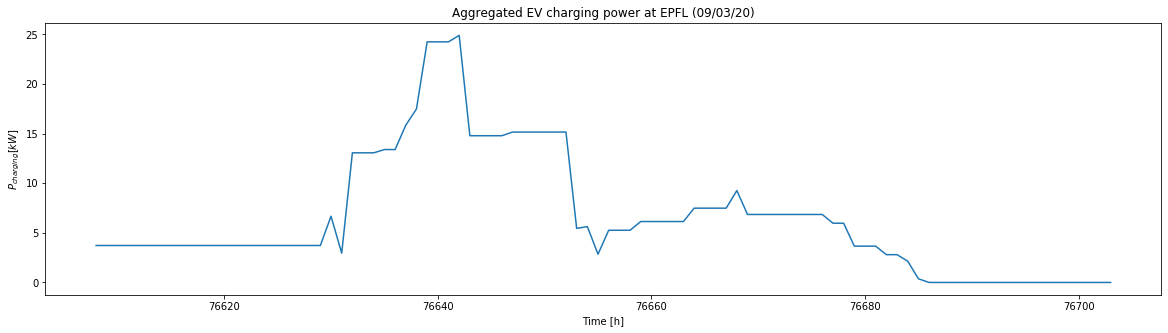

In [275]:
plt.figure(figsize=(20,5))
plt.plot(aa)
plt.title('Aggregated EV charging power at EPFL (09/03/20)')
plt.ylabel(r'$P_{charging} [kW]$')
plt.xlabel('Time [h]')

### A.3 Add weather data

In [354]:
cs_weather = pd.read_csv('{}/weather.csv'.format(DATA_FOLDER), index_col = None)

/Users/mac/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [355]:
Cha = ['Year','Month','Day','Hour','TMP','WNDCHILL','WNDSPD','Humidity','PRMSL','RAIN']
cs_weather = cs_weather[Cha]

In [356]:
cs_weather['RAIN'] = cs_weather['RAIN']\
.apply(lambda x: float(x.split('/')[0]) if x != '--' else float(0))

In [357]:
weather = cs_weather.reset_index(drop=True)

In [358]:
weather['Hour'] = weather['Hour'].apply(lambda x: int(x.split(':')[0]))

##### fill up the '--' with average value

In [359]:
weather['TMP'] = weather.apply(lambda x: float(x.TMP) if x.TMP != '--'\
                             else weather[(weather.Month == x.Month)\
                                         & (weather.Hour == x.Hour)\
                                         & (weather.TMP != '--')]['TMP'].apply(float).mean(), axis=1)

In [360]:
weather['WNDCHILL'] = weather.apply(lambda x: float(x.WNDCHILL) if x.WNDCHILL != '--'\
                             else weather[(weather.Month == x.Month)\
                                         & (weather.Hour == x.Hour)\
                                         & (weather.WNDCHILL != '--')]['WNDCHILL'].apply(float).mean(), axis=1)

In [361]:
weather['WNDSPD'] = weather.apply(lambda x: float(x.WNDSPD) if x.WNDSPD != '--'\
                             else weather[(weather.Month == x.Month)\
                                         & (weather.Hour == x.Hour)\
                                         & (weather.WNDSPD != '--')]['WNDSPD'].apply(float).mean(), axis=1)

In [362]:
weather['Humidity'] = weather.apply(lambda x: float(x.Humidity) if x.Humidity != '--'\
                             else weather[(weather.Month == x.Month)\
                                         & (weather.Hour == x.Hour)\
                                         & (weather.Humidity != '--')]['Humidity'].apply(float).mean(), axis=1)

In [363]:
weather['PRMSL'] = weather.apply(lambda x: float(x.PRMSL) if x.PRMSL != '--'\
                             else weather[(weather.Month == x.Month)\
                                         & (weather.Hour == x.Hour)\
                                         & (weather.PRMSL != '--')]['PRMSL'].apply(float).mean(), axis=1)

In [364]:
weather['RAIN'] = weather.apply(lambda x: float(x.RAIN) if x.PRMSL != '--'\
                             else weather[(weather.Month == x.Month)\
                                         & (weather.Hour == x.Hour)\
                                         & (weather.RAIN != '--')]['RAIN'].apply(float).mean(), axis=1)

In [365]:
weather['Time'] = weather.apply\
(lambda x: datetime.datetime(int(x.Year),int(x.Month),int(x.Day),int(x.Hour)), axis =1)

In [366]:
weather = weather.drop(['Year','Month','Day'], axis = 1)

In [367]:
weather = weather[['Time','TMP','WNDCHILL','WNDSPD','Humidity','PRMSL','RAIN']]

In [368]:
weather = weather.drop_duplicates(subset=None, keep='first', inplace=False)

In [369]:
weather = weather.drop_duplicates(subset=['Time'], keep='first', inplace=False)

###  A.4 join power and weather set together and got season, weekday/weekenday info.

In [374]:
power_list['Day'] = power_list['Date'].dt.date

In [375]:
power_list['Hour'] = power_list['Date'].dt.hour

In [378]:
weather['Day'] = weather['Time'].dt.date

In [379]:
weather['Hour'] = weather['Time'].dt.hour

In [380]:
weather = weather.drop(['Time'], axis = 1)

In [381]:
df_GM = pd.merge(power_list, weather, how ='left', on=['Day','Hour'])

In [384]:
df_GM = df_GM.drop(['Day','Hour'], axis = 1)

#### complete season info.

In [410]:
season = {1:'Winter', 2:'Winter', 3:'Spring', 4:'Spring', 5:'Spring', 6:'Summer', 7:'Summer',\
         8:'Summer', 9:'Fall', 10:'Fall', 11:'Fall', 12:'Winter'}

In [411]:
df_GM['Season'] = df_GM.apply(lambda x: season[x.Date.month], axis=1)

In [417]:
df_GM['weekday'] = df_GM['Date'].apply(lambda x: x.weekday() + 1)

In [420]:
df_GM['weekday'] = df_GM['weekday'].apply(lambda x: 1 if x < 6 else 0)

In [421]:
df_GM.head()

,Date,Power,TMP,WNDCHILL,WNDSPD,Humidity,PRMSL,RAIN,Season,weekday
0,2018-01-02 00:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Winter,1
1,2018-01-02 00:15:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Winter,1
2,2018-01-02 00:30:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Winter,1
3,2018-01-02 00:45:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Winter,1
4,2018-01-02 01:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,Winter,1


In [422]:
df_GM.to_csv('data/power_data_15minutes.csv',index = False)